In [1]:
import pandas as pd
import numpy as np
import datetime 
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data = pd.read_csv('Traffic_Crashes_-_Crashes.csv')

In [4]:
### Setting up the data table again

In [5]:
data=data.drop(['STATION','NAME','DATE','CRASH_DATE','POSTED_SPEED_LIMIT','CRASH_DATE_ADJ'], axis=1)
columns = ['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'BEAT_OF_OCCURRENCE']
for col in columns:
    tmp_df = pd.get_dummies(data[col], prefix=col)
    data = pd.concat((data, tmp_df), axis=1)
data=data.drop(['WEATHER_CONDITION','LIGHTING_CONDITION','BEAT_OF_OCCURRENCE'], axis=1)
data=data.drop(['COUNTER'], axis=1)
data['INJURIES_TOTAL'].apply(lambda x: (x and 0) or x > 1)
data['ACCIDENT_LEVEL']=(data['INJURIES_TOTAL'] > 0).astype(int)
data=data.drop(['INJURIES_TOTAL','INJURIES_FATAL'], axis=1)
X = data.iloc[:, 0:293]
y = data.ACCIDENT_LEVEL

In [8]:
#Check out y counts for no injures and injuries

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [118]:
y_test.value_counts()

0    16408
1     2081
Name: ACCIDENT_LEVEL, dtype: int64

In [7]:
y_train.value_counts()

0    147945
1     18449
Name: ACCIDENT_LEVEL, dtype: int64

In [9]:
# Upsampling to even out ratios 

In [55]:
from collections import Counter
import imblearn.under_sampling

RUS = imblearn.under_sampling.RandomUnderSampler(\
                                     ratio={0:int(147945/6), 1:int(18449)}, \
                                     random_state = 42)
    
X_tr_RUS, y_tr_RUS = RUS.fit_sample(X_train,y_train)


'''Increase the injuries samples from 147,945 to 24,657.5'''

print('Resampled dataset shape {}'.format(Counter(y_tr_RUS)))

Resampled dataset shape Counter({0: 24657, 1: 18449})


In [11]:
#Train, Test, Split

In [56]:
'''Split the resampled data into train & test data with 70:30 mix'''

Xtrain_res, Xtest_res, ytrain_res, ytest_res = train_test_split(X_tr_RUS, y_tr_RUS, test_size=0.30, random_state=0)
print('xtrain shape')
print(Xtrain_res.shape)
print('xtest shape')
print(Xtest_res.shape)

xtrain shape
(30174, 293)
xtest shape
(12932, 293)


### Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression

logitreg_gs = LogisticRegression()
parameters = {'penalty':['l1','l2'] , 'C' : [15,16,17,18,19,20,21], 'random_state': [44]}
grid_lr = GridSearchCV(logitreg_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
grid_lr.fit(X_tr_RUS, y_tr_RUS)
print(grid_lr.best_params_, grid_lr.best_score_)
#15 

{'C': 16, 'penalty': 'l2', 'random_state': 44} 0.5615819162352816


In [80]:
print(classification_report(y_train, grid_lr.predict(X_train)))
print(confusion_matrix(y_train, grid_lr.predict(X_train)))


             precision    recall  f1-score   support

          0       0.90      0.81      0.86    147945
          1       0.17      0.31      0.22     18449

avg / total       0.82      0.76      0.79    166394

[[120565  27380]
 [ 12763   5686]]


In [81]:
print(classification_report(y_test, grid_lr.predict(X_test)))
print(confusion_matrix(y_test, grid_lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.90      0.81      0.86     16408
          1       0.17      0.30      0.22      2081

avg / total       0.82      0.76      0.78     18489

[[13337  3071]
 [ 1452   629]]


## KNN Undersampling

In [15]:
from sklearn.neighbors import KNeighborsClassifier


In [17]:
n_neighbors = range(1,12)
knn_accuracy = list()
knn_recall = list()

for n in n_neighbors:
    knn = KNeighborsClassifier(n)
    knn.fit(Xtrain_res, ytrain_res)
    knn_prediction = knn.predict(X_test)
    knn_accuracy.append(accuracy_score(y_test, knn_prediction))
    knn_recall.append(recall_score(y_test, knn_prediction))
    

Text(0.5,1,'KNN Model - Accuracy, Recall vs Neighbors')

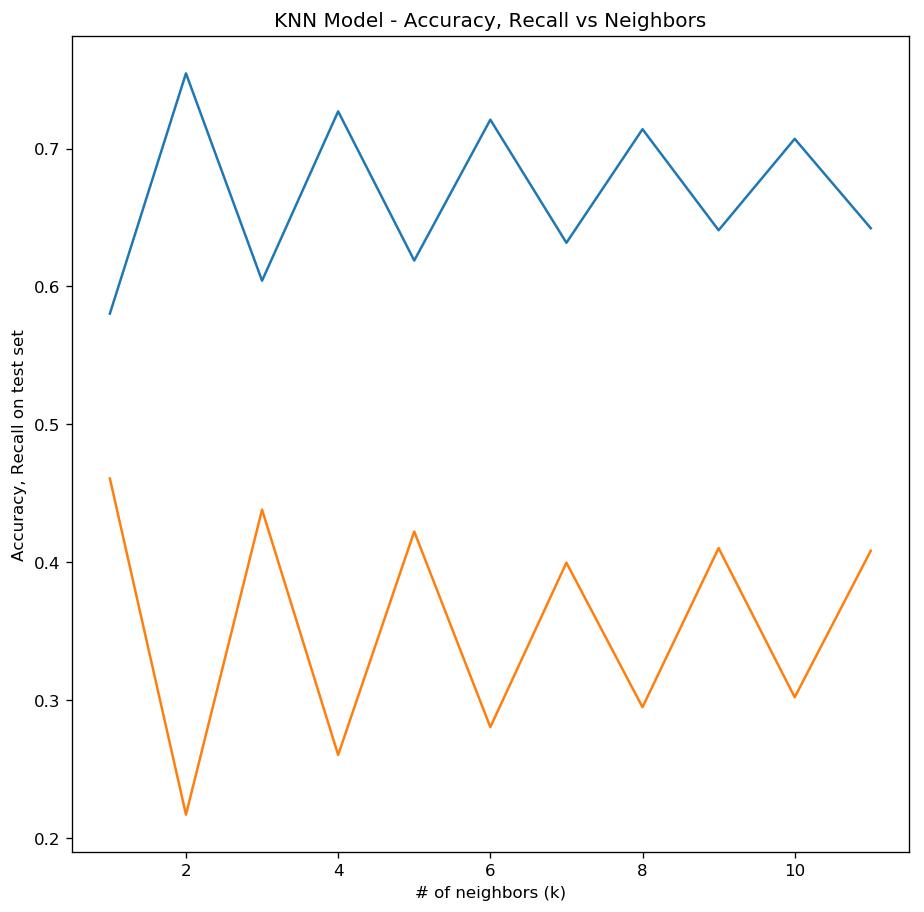

In [18]:
plt.figure(figsize=(9,9), dpi=120)
plt.plot(n_neighbors, knn_accuracy)
plt.plot(n_neighbors, knn_recall)
plt.xlabel('# of neighbors (k)')
plt.ylabel('Accuracy, Recall on test set')
plt.title('KNN Model - Accuracy, Recall vs Neighbors')

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(Xtrain_res, ytrain_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [38]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, knn.predict(X_train)))
print(confusion_matrix(y_test, knn.predict(X_test)))

[[96539 51406]
 [ 7073 11376]]
[[10259  6149]
 [ 1169   912]]


In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(Xtrain_res, ytrain_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [40]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, knn.predict(X_train)))
print(confusion_matrix(y_test, knn.predict(X_test)))

[[98489 49456]
 [ 8137 10312]]
[[10562  5846]
 [ 1202   879]]


In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7) 
knn.fit(Xtrain_res, ytrain_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [67]:
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, knn.predict(X_test)))
print(confusion_matrix(y_train, knn.predict(X_train)))
print(confusion_matrix(y_test, knn.predict(X_test)))

             precision    recall  f1-score   support

          0       0.90      0.66      0.76     16408
          1       0.13      0.40      0.20      2081

avg / total       0.81      0.63      0.70     18489

[[100947  46998]
 [  8866   9583]]
[[10847  5561]
 [ 1249   832]]


# Naive Baise SMOTE

In [21]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(Xtrain_res, ytrain_res)
print(nb.score(X_train, y_train))
print(nb.score(X_test, y_test))

0.5881041383703739
0.5865649845854292


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
print(classification_report(y_train, nb.predict(X_train)))
print(confusion_matrix(y_train, nb.predict(X_train)))


             precision    recall  f1-score   support

          0       0.91      0.60      0.72    147945
          1       0.14      0.53      0.22     18449

avg / total       0.82      0.59      0.66    166394

[[88119 59826]
 [ 8711  9738]]


In [24]:
print(classification_report(y_test, nb.predict(X_test)))
print(confusion_matrix(y_test, nb.predict(X_test)))


             precision    recall  f1-score   support

          0       0.91      0.60      0.72     16408
          1       0.14      0.52      0.22      2081

avg / total       0.82      0.59      0.66     18489

[[9771 6637]
 [1007 1074]]


# Random Forest SMOTE

In [28]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics as mt

### Gridsearch on Random Forest

In [57]:
rfgrid = RandomForestClassifier()
parameters = {'n_estimators': [26,27,28,29,30], 'criterion':['gini','entropy'],'max_features': ['auto', 'sqrt'], 'random_state': [2]}
gridrf = GridSearchCV(rfgrid , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridrf.fit(Xtrain_res, ytrain_res)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [26, 27, 28, 29, 30], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt'], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [59]:
print(gridrf.best_params_, gridrf.best_score_)

#27** befrorerfefreferrj

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 27, 'random_state': 2} 0.5523485975013754


## Testing on regular data with fitted random forest 

In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 27) #24 #22 #20
rf.fit(Xtrain_res, ytrain_res)

rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=3)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87313433 0.87051761 0.87455372]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.90      0.69      0.78     16408
          1       0.14      0.40      0.21      2081

avg / total       0.81      0.66      0.72     18489

[[11387  5021]
 [ 1259   822]]


In [84]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion= 'gini',n_estimators = 27) #24 #22 #20
rf.fit(Xtrain_res, ytrain_res)

rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=3)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87 0.87 0.87]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.90      0.70      0.79     16408
          1       0.14      0.38      0.20      2081

avg / total       0.81      0.67      0.72     18489

[[11541  4867]
 [ 1300   781]]


# Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier


dt = DecisionTreeClassifier()

In [82]:
dt.fit(Xtrain_res, ytrain_res)
dt.score(Xtest_res, ytest_res)

0.8878248696463714

### Gridsearch on Decision Tree

In [63]:
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': [5,10,15,20], 'random_state': [3]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 20], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [64]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'random_state': 3} 0.8371154631195373


In [65]:
print(mt.classification_report(y_test, dt_gs.predict(X_test)))
print(mt.confusion_matrix(y_test, dt_gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     16408
          1       0.14      0.00      0.00      2081

avg / total       0.80      0.89      0.83     18489

[[16402     6]
 [ 2080     1]]


# XGBoosted

In [53]:
import xgboost as xgb


Xtrain_res_, Xtrain_res_val_, ytrain_res_, ytrain_res_val_ = train_test_split(Xtrain_res, ytrain_res, test_size=0.25, random_state=41)




In [54]:
gbm = xgb.XGBClassifier(
                       n_estimators=800000, #arbitrary large number
                       max_depth=7,
                       objective='binary:logistic',
                       learning_rate=.08, #.1
                       subsample=1,
                       min_child_weight=6, #
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=9,
                    verbose=True #gives output log as below
                   )

NameError: name 'X_val' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.10)

# BEST MODEL: Random Forest

In [88]:
import itertools
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges): #plt.cm.Oranges
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (100*cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('')
    plt.xlabel('')

In [90]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 3, x.max() + 3
    y_min, y_max = y.min() - 10, y.max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, X, y, **params):
    """
    Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

Confusion matrix, without normalization
[[13337  3071]
 [ 1452   629]]
Normalized confusion matrix
[[81.28 18.72]
 [69.77 30.23]]


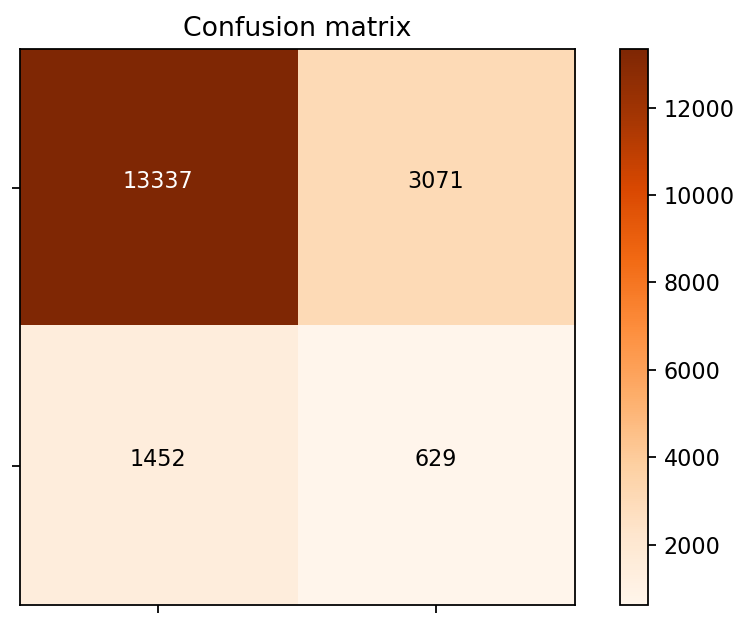

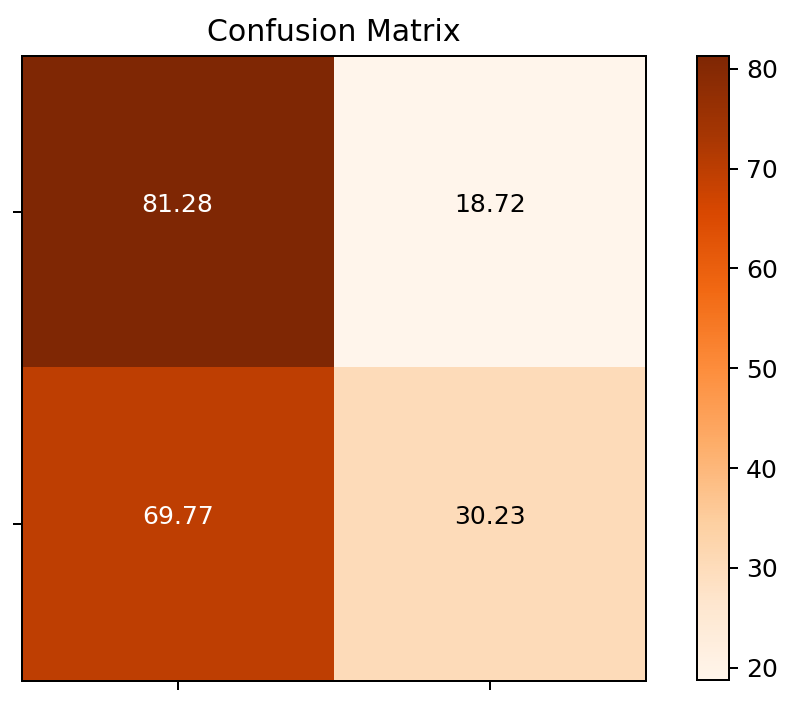

In [89]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, grid_lr.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()

# CORRECTED DOWNSAMPLING!
# CORRECTED DOWNSAMPLING!
# CORRECTED DOWNSAMPLING!

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.10)

In [151]:
y_train.value_counts()

0    147917
1     18477
Name: ACCIDENT_LEVEL, dtype: int64

In [152]:
y_test.value_counts()

0    16436
1     2053
Name: ACCIDENT_LEVEL, dtype: int64

In [156]:
RUS = imblearn.under_sampling.RandomUnderSampler(\
                                     ratio={0:int(147917/6), 1:int(18477)}, \
                                     random_state = 42)
    
X_tr_RUS, y_tr_RUS = RUS.fit_sample(X_train,y_train)


'''Increase the injuries samples from 147,945 to 24,652'''

print('Resampled dataset shape {}'.format(Counter(y_tr_RUS)))

Resampled dataset shape Counter({0: 24652, 1: 18477})


In [158]:
'''Split the resampled data into train & test data with 70:30 mix'''

Xtrain_res, Xtest_res, ytrain_res, ytest_res = train_test_split(X_tr_RUS, y_tr_RUS, stratify=y_tr_RUS, test_size=0.30, random_state=0)
print('xtrain shape')
print(Xtrain_res.shape)
print('xtest shape')
print(Xtest_res.shape)

xtrain shape
(30190, 293)
xtest shape
(12939, 293)


In [ ]:
#Logistic

In [184]:
from sklearn.linear_model import LogisticRegression

logitreg_gs = LogisticRegression()
parameters = {'penalty':['l1','l2'] , 'C' : [30,31,32], 'random_state': [44]}
grid_lr = GridSearchCV(logitreg_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
grid_lr.fit(Xtrain_res, ytrain_res)
print(grid_lr.best_params_, grid_lr.best_score_)
#15 

{'C': 31, 'penalty': 'l2', 'random_state': 44} 0.5552434272202452


In [185]:
print("TRAIN")
print(classification_report(y_train, grid_lr.predict(X_train)))
print(confusion_matrix(y_train, grid_lr.predict(X_train)))
print("TEST")
print(classification_report(y_test, grid_lr.predict(X_test)))
print(confusion_matrix(y_test, grid_lr.predict(X_test)))

TRAIN
             precision    recall  f1-score   support

          0       0.90      0.81      0.86    147917
          1       0.17      0.30      0.22     18477

avg / total       0.82      0.76      0.79    166394

[[120428  27489]
 [ 12879   5598]]
TEST
             precision    recall  f1-score   support

          0       0.90      0.81      0.85     16436
          1       0.17      0.30      0.21      2053

avg / total       0.82      0.75      0.78     18489

[[13323  3113]
 [ 1436   617]]


In [ ]:
# Random Forest

In [166]:
rfgrid = RandomForestClassifier()
parameters = {'criterion':['gini','entropy'],'n_estimators': [26,27,28,29,30,31], 'random_state': [2]}
gridrf = GridSearchCV(rfgrid , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
gridrf.fit(Xtrain_res, ytrain_res)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [26, 27, 28, 29, 30, 31], 'random_state': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [167]:
print(gridrf.best_params_, gridrf.best_score_)

{'criterion': 'entropy', 'n_estimators': 29, 'random_state': 2} 0.5535991400421004


In [180]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 29) #28! Try this #
rf.fit(Xtrain_res, ytrain_res)

rf_predictions = rf.predict(X_test)

#print(rf.score(X_test, y_test))
scores = cross_val_score(rf, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print(mt.classification_report(y_test, rf_predictions))
print(mt.confusion_matrix(y_test, rf_predictions))

[0.87 0.87 0.87 0.87 0.87]
Accuracy: 0.87 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.90      0.70      0.79     16436
          1       0.14      0.40      0.21      2053

avg / total       0.82      0.66      0.72     18489

[[11473  4963]
 [ 1241   812]]


In [ ]:
# Decision Tree

In [181]:
dt_gs = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': [5,10,15,20], 'random_state': [3]}
dt_gs = GridSearchCV(dt_gs , parameters, cv=3, scoring='f1_weighted', n_jobs=1)
dt_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 20], 'random_state': [3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [182]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'random_state': 3} 0.836872339365781


In [183]:
print(mt.classification_report(y_test, dt_gs.predict(X_test)))
print(mt.confusion_matrix(y_test, dt_gs.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94     16436
          1       0.10      0.00      0.00      2053

avg / total       0.80      0.89      0.84     18489

[[16410    26]
 [ 2050     3]]


Confusion matrix, without normalization
[[13323  3113]
 [ 1436   617]]
Normalized confusion matrix
[[81.06 18.94]
 [69.95 30.05]]


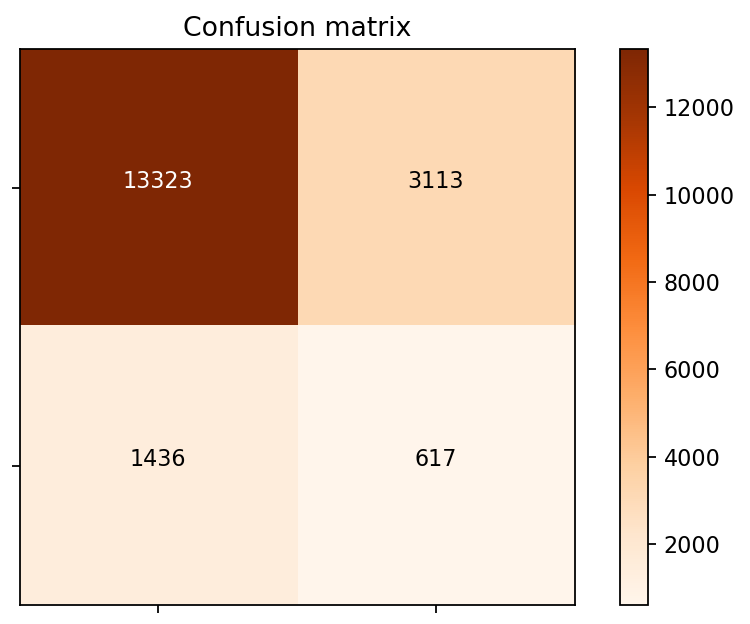

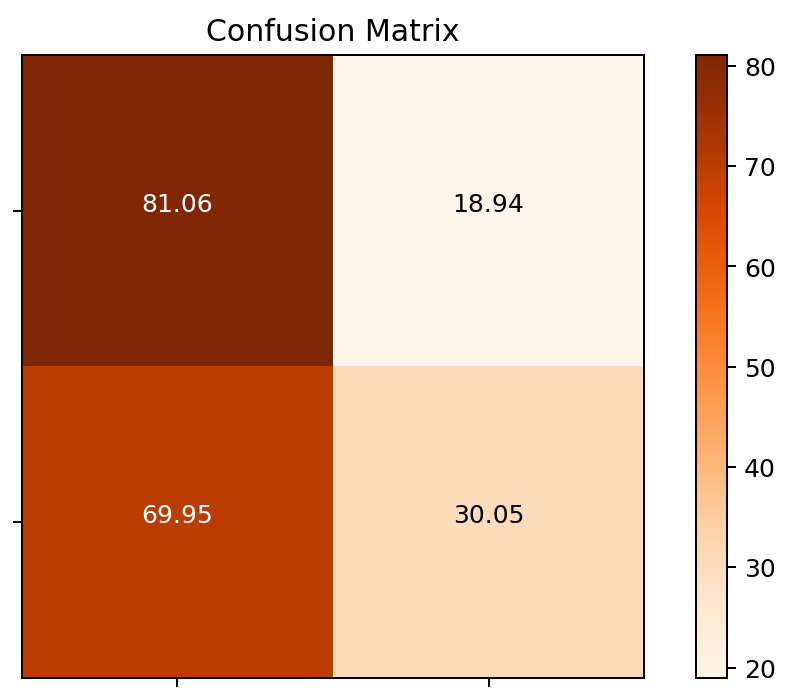

In [186]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, grid_lr.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=160)
plot_confusion_matrix(cnf_matrix, classes=['', ''], title='Confusion matrix')

# Plot normalized confusion matrix
plt.figure(dpi=180)
plot_confusion_matrix(cnf_matrix, classes=['', ''], normalize=True, title='Confusion Matrix')

plt.show()

In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
pcafeatures_train = pca.transform(X_train)

In [109]:
datanames = ['injury', 'no_injury']

In [255]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['blue','orange'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10)) #dpi = 160
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c,s=80, alpha = .9, label=label, edgecolors='gray')
    plt.legend()

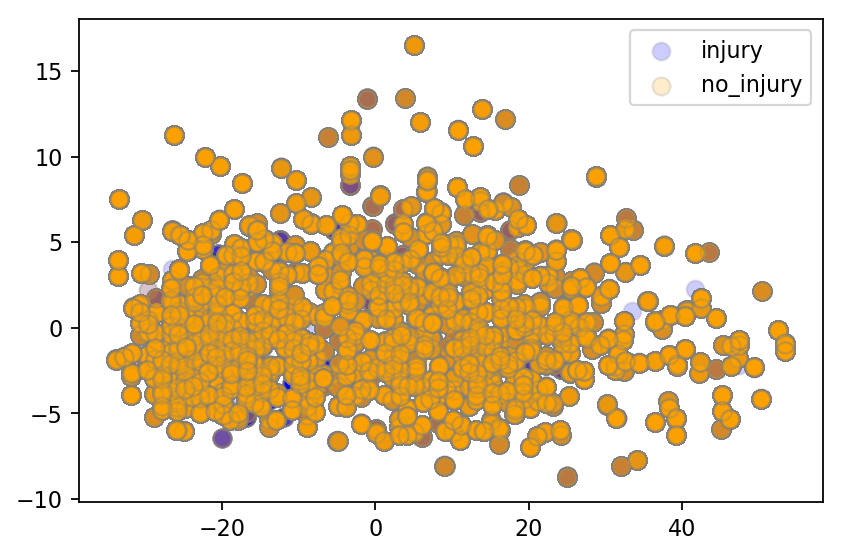

In [177]:
plot_PCA_2D(pcafeatures_train, target=y_train, target_names=datanames)

In [239]:
pca = PCA(n_components=2)
pca.fit(X_test)
pcafeatures_test = pca.transform(X_test)

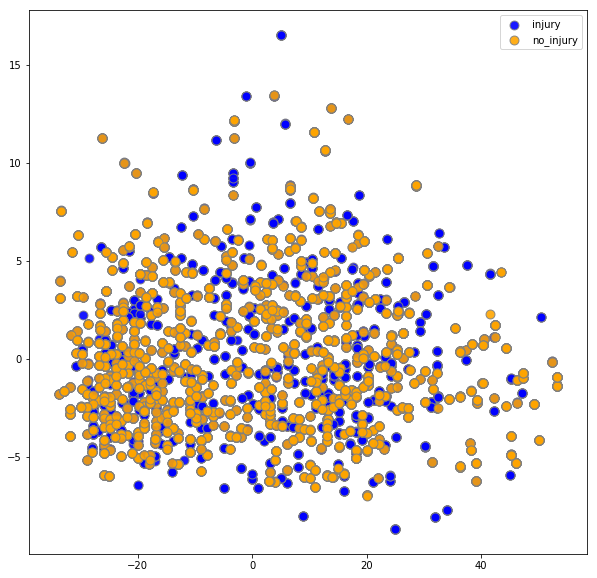

In [256]:
plot_PCA_2D(pcafeatures_test, target=y_test, target_names=datanames)

In [ ]:
orange, blue